Using:
    https://gist.github.com/EdwardJRoss/86b31848a7951411de56f10f55e9de4e
    https://forums.fast.ai/t/character-level-language-model/31379
    
Lesson 4 RNN


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.text import *
import string
from unidecode import unidecode
from scipy import linalg

## Simple example

To understand it

In [113]:
A = array([[10,0,0,30,20,0], [30,0,0,10,20,0], [0,20,30,0,0,10],[20,0,0,20,30,0],[0,20,30,0,0,20]
           ,[0,30,30,0,0,10],[50,0,0,30,60,0]])

In [138]:
A2 = array([[1,0,0,3,2,0], [3,0,0,1,2,0], [0,2,3,0,0,1],[2,0,0,2,3,0],[0,2,3,0,0,2]
           ,[0,3,3,0,0,1],[5,0,0,3,6,0]])

In [139]:
U, s, VT = linalg.svd(A)

In [141]:
U2, s2, VT2 = linalg.svd(A2)

In [116]:
print(U)
print(s)
print(VT)

[[-3.097382e-01  2.103239e-16  8.445550e-01 -1.439169e-16  3.812276e-01  3.739528e-16  2.132007e-01]
 [-3.399443e-01  1.617456e-16 -4.347678e-01 -3.909354e-16  8.062011e-01  2.786990e-16 -2.132007e-01]
 [ 6.190139e-19  5.327698e-01 -7.979174e-17  5.716015e-02 -2.072117e-16  8.443276e-01  2.220446e-16]
 [-3.910619e-01 -1.164016e-16  1.995256e-01 -4.663722e-16 -2.828204e-01 -2.242653e-16 -8.528029e-01]
 [ 9.029169e-19  5.800513e-01 -1.163872e-16 -7.511422e-01 -3.022468e-16 -3.151601e-01  7.569452e-16]
 [-9.029169e-19  6.161955e-01  1.163872e-16  6.576611e-01  3.022468e-16 -4.333417e-01 -1.342719e-16]
 [-7.972269e-01 -9.255147e-17 -2.406103e-01  4.498935e-16 -3.531541e-01 -1.523039e-16  4.264014e-01]]
[104.676504  69.8832    21.799782   9.870251   8.221858   4.349309]
[[-5.825404e-01  0.000000e+00  0.000000e+00 -4.244471e-01 -6.931749e-01  0.000000e+00]
 [ 0.000000e+00  5.830054e-01  7.422456e-01 -1.428398e-16  1.804656e-16  3.304182e-01]
 [-5.797070e-01  5.551115e-17  0.000000e+00  8.147

In [117]:
np.argsort(VT)

array([[4, 0, 3, 1, 2, 5],
       [3, 0, 4, 5, 1, 2],
       [0, 4, 2, 5, 1, 3],
       [5, 2, 0, 3, 4, 1],
       [4, 1, 2, 5, 3, 0],
       [1, 5, 3, 4, 0, 2]])

In [142]:
np.argsort(VT2)

array([[4, 0, 3, 1, 2, 5],
       [3, 0, 4, 5, 1, 2],
       [0, 4, 1, 2, 5, 3],
       [5, 2, 4, 0, 3, 1],
       [4, 1, 2, 5, 3, 0],
       [1, 5, 3, 0, 4, 2]])

## Prepare data

Load in the data

In [6]:
df = pd.read_csv('/home/trpb2/data/takeaway/raw_just_eat_multi.csv')

In [7]:
df.head()

,label1,label2,label3,text
0,Middle Eastern,Grill,NaN,taste of afghanistan
1,Middle Eastern,Kebab,NaN,masa restaurant harrow
2,Middle Eastern,Kebab,NaN,kobeda king
3,Middle Eastern,Indian,NaN,taste of afghan
4,Middle Eastern,Middle Eastern,NaN,ariana restaurant


In [69]:
df_cross = pd.crosstab(df['label2'], df['label1'], dropna=True)

In [130]:
type(df_cross.American)

pandas.core.series.Series

In [71]:
%time U, s, Vh = linalg.svd(df_cross, full_matrices=True)

CPU times: user 0 ns, sys: 573 µs, total: 573 µs
Wall time: 575 µs


In [72]:
print(U.shape, s.shape, Vh.shape)

(26, 26) (26,) (26, 26)


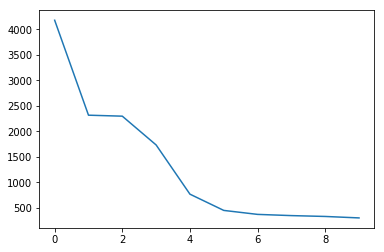

In [73]:
plt.plot(s[:10])

In [99]:
s

array([4.181560e+03, 2.316083e+03, 2.296723e+03, 1.731224e+03, 7.642762e+02, 4.449425e+02, 3.668819e+02, 3.430166e+02,
       3.262590e+02, 2.975613e+02, 2.889816e+02, 2.165430e+02, 2.020427e+02, 1.208416e+02, 1.102303e+02, 8.326939e+01,
       7.506733e+01, 7.395067e+01, 5.507604e+01, 3.473805e+01, 3.039494e+01, 2.279083e+01, 2.092244e+01, 1.273709e+01,
       5.641026e+00, 2.998148e+00])

In [85]:
vocab = df_cross.columns.values
num_top_words = 3

In [9]:
def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [87]:
show_topics(Vh[:10])

['Noodles Japanese Sandwiches',
 'Indian Sandwiches British',
 'Chinese Thai Indian',
 'Italian Kebab Chicken',
 'Desserts Burgers Breakfast',
 'Fish & Chips Turkish Desserts',
 'Chicken Breakfast Sandwiches',
 'Caribbean Burgers Fish & Chips',
 'Chicken Caribbean American',
 'Fish & Chips Burgers Chinese']

In [98]:
Vh.shape,Vh[:10]

((26, 26),
 array([[-8.136001e-03, -1.761384e-03, -1.523443e-03, -9.248221e-04, ..., -8.519482e-02, -5.867389e-04, -7.206973e-03,
         -9.425864e-03],
        [-4.631174e-02, -1.152130e-02, -1.524997e-02, -4.328576e-03, ..., -7.560781e-01, -4.069314e-03, -3.920102e-02,
         -8.313406e-02],
        [-3.129832e-02,  1.500822e-02, -8.611108e-03, -2.138320e-03, ..., -5.280876e-01, -2.613023e-03,  6.061425e-02,
         -5.805050e-02],
        [ 5.776551e-02, -8.094388e-04,  5.518020e-03,  5.149626e-03, ..., -3.051670e-01,  3.537164e-03, -2.610700e-03,
         -1.882366e-02],
        ...,
        [-5.500741e-02, -1.004411e-01,  7.112017e-02,  1.577031e-01, ...,  2.830311e-03, -5.321939e-02,  5.302666e-02,
          1.217678e-01],
        [-9.214771e-02, -7.402005e-02,  3.495077e-01, -2.947950e-01, ..., -3.223868e-03, -1.883182e-01,  6.267464e-02,
         -9.853595e-03],
        [-2.572796e-01,  1.181674e-01, -1.286856e-01, -8.121070e-02, ...,  2.258461e-02,  8.580010e-02, -1.29442

In [94]:
for t in Vh[:10]:
    print(np.argsort(t))

[13 22 16 14 11  6  7  4 25  0  8 12 24 21  9 17  5  1  2 19 10  3 18 23 15 20]
[22  7 11 14  6 16 25  4  0 24 21  9 12  8 17  2 15  1 19 18 10  5 20  3 23 13]
[22 11 14  6 16 25  4  0 21  9 12 17  8  2 19 18  5 23  3 10 20  1 15 13 24  7]
[22 13 25  7 24  1 19 20 15 17  5 23  3  2  9 18 10  8 12 21  4  0 11  6 16 14]
[11 25 14 22 16 17  8 19  7 20 24 13 15 18 10 12  1  3 21  5  6  0 23  2  4  9]
[ 4  6 21  5  0 23  2 18 16 12 24  1  7 15 13 22 20  3 10 17 19  8 14  9 25 11]
[14  4 22  9  7 15 24  1 13 20  8 19 10 18 21 25 17 12 16  3  0  5 11 23  2  6]
[ 6  0 16 22  2  9 15 18  7 12 24 20 13  1 10  8 19 23 17  3 14 25 21 11  4  5]
[23  2  4 14  3 11 25 17 10 19  1 13  7 24 18 20  8 15 21 22 12  9 16  0  5  6]
[15  1 24  5 23 14 22 20  2 16 17  0 19 18 10 13  8  9 12  3 25  6 21  7  4 11]


## Prepare data

Load in the data

In [118]:
df4 = pd.read_csv('names_clean_multi.csv')

In [135]:
df5 = df4.drop(['ascii_name_fix', 'valid', 'bal'], axis=1)

In [144]:
vocab = df5.columns.values

In [146]:
%time U, s, Vh = linalg.svd(df5, full_matrices=False)

CPU times: user 32.1 s, sys: 724 ms, total: 32.8 s
Wall time: 32.7 s


In [147]:
show_topics(Vh[:10])

['Japanese Noodles Caribbean',
 'Pizza Kebab Italian',
 'Chinese Kebab Fish & Chips',
 'Chinese Italian Pizza',
 'Italian Kebab Pizza',
 'Kebab Chicken Chinese',
 'Chicken Peri Peri Pizza',
 'Italian Chicken Kebab',
 'Burgers Curry Pizza',
 'Curry Desserts Thai']

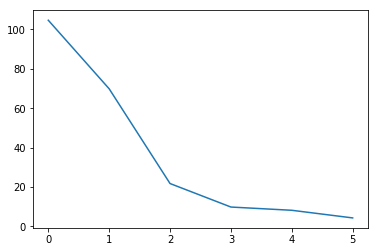

In [143]:
plt.plot(s[:10])

## K mode input

In [5]:
df = pd.read_csv('kmode_input.csv')

In [14]:
vocab = df.columns.values
num_top_words = 5

In [15]:
%time U, s, Vh = linalg.svd(df, full_matrices=False)

CPU times: user 321 ms, sys: 12.9 ms, total: 334 ms
Wall time: 331 ms


In [16]:
show_topics(Vh[:100])

['West African Filipino Organic Ethiopian Latin American',
 'Indian Curry Bangladeshi Nepalese Pakistani',
 'Chinese Oriental Thai Noodles Fish & Chips',
 'Kebab Fish & Chips Turkish Grill British',
 'Burgers Chicken American Peri Peri Fish & Chips',
 'Kebab Chicken Oriental Turkish American',
 'Chicken Peri Peri Pizza Fish & Chips Grill',
 'Italian Chicken Kebab American Fish & Chips',
 'Burgers Curry Pizza Italian Oriental',
 'Indian Bangladeshi Grill Nepalese Vegetarian',
 'Desserts Burgers American Fish & Chips Ice Cream',
 'Grill Turkish Peri Peri American Lebanese',
 'American Breakfast English Pizza Sandwiches',
 'Thai Noodles Chinese Asian Japanese',
 'Peri Peri Kebab Grill Italian Thai',
 'Thai Oriental Grill Chicken Bangladeshi',
 'Peri Peri Turkish Thai Oriental Mediterranean',
 'Caribbean Jamaican Peri Peri English Oriental',
 'English Indian Thai Nepalese Chinese',
 'Indian Japanese Sushi Oriental Nepalese',
 'English Oriental Japanese Sushi Thai',
 'British English Pies  

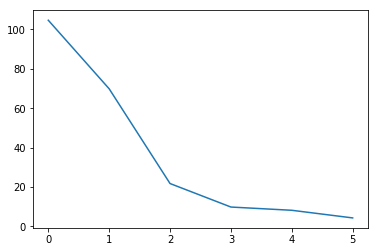

In [143]:
plt.plot(s[:10])